# Chapter 26: Stream Iteration and Filtering

this chapter will delve deeper into the concept of iteration, and filtering out elements so only those in classes or areas you want are found

In [1]:
from music21 import *

**Streams**, as we have seen, are iterable

In [2]:
s = stream.Part(id='restyStream')
s.append(note.Note('C#'))
s.append(note.Rest(quarterLength=2.0))
s.append(note.Note('D', quarterLength=1.5))
s.append(note.Rest(quarterLength=1.0))

for thing in s:
    print(thing, thing.quarterLength)

<music21.note.Note C#> 1.0
<music21.note.Rest half> 2.0
<music21.note.Note D> 1.5
<music21.note.Rest quarter> 1.0


We can create one directly by calling ***.iter()*** on any stream

In [3]:
sIter = s.iter()
sIter

<music21.stream.iterator.StreamIterator for Part:restyStream @:0>

We can get the next thing in the Stream by calling ***next()*** on the Stream

In [4]:
next(sIter)

<music21.note.Note C#>

In [5]:
next(sIter)

<music21.note.Rest half>

In [6]:
sIter

<music21.stream.iterator.StreamIterator for Part:restyStream @:2>

built in way of going through an iterable

In [7]:
for el in sIter:
    print(el, el.quarterLength)

<music21.note.Note C#> 1.0
<music21.note.Rest half> 2.0
<music21.note.Note D> 1.5
<music21.note.Rest quarter> 1.0


## Filtering elements in iteration

Most importantly, a *StreamIterator* can add **filters** to it

In [8]:
restFilter = stream.filters.ClassFilter('Rest')
restIterator = sIter.addFilter(restFilter)
for el in restIterator:
    print(el, el.quarterLength)

<music21.note.Rest half> 2.0
<music21.note.Rest quarter> 1.0


We can also filter by offset

In [9]:
sIter2 = s.iter()
offsetFilter = stream.filters.OffsetFilter(offsetStart=0.5, offsetEnd=4.0)
offsetIterator = sIter2.addFilter(offsetFilter)
for el in offsetIterator:
    print(el, el.offset)

<music21.note.Rest half> 1.0
<music21.note.Note D> 3.0


**Multiple filters** can be chained together to get something more powerful

In [10]:
for el in s.iter().addFilter(restFilter).addFilter(offsetFilter):
    print(el, el.offset)

<music21.note.Rest half> 1.0


## Filter Shortcuts

Filtering elements by offset or by class is so common, that *music21* has some shortcuts for adding filters to it, like this

In [11]:
sIter4 = s.iter()
restIterator = sIter4.getElementsByClass('Rest')
restOffsetIterator = restIterator.getElementsByOffset(0.5, 4.0)
for el in restOffsetIterator:
    print(el, el.offset)

<music21.note.Rest half> 1.0


you can chain them right in the for loop

In [12]:
for el in s.iter().getElementsByClass('Rest').getElementsByOffset(0.5, 4.0):
    print(el, el.offset)

<music21.note.Rest half> 1.0


you can even **skip** the *s.iter()* step for getting an iterator for the most common of these filters

In [13]:
for el in s.getElementsByClass('Rest').getElementsByOffset(0.5, 4.0):
    print(el, el.offset)

<music21.note.Rest half> 1.0


The shortcut methods that music21 exposes on Iterators include

**getElementById()** which adds an IdFilter

**getElementsByClass()** which adds a ClassFilter

**getElementsByGroup()** which adds a GroupFilter

**getElementsByOffset()** which adds an OffsetFilter

And there are also properties which add certain filters:

**notes** which filters out everything but Note and Chord objects

**notesAndRests** which filters out everything except GeneralNote objects

**parts** which returns all the Part objects

## Custom Filters

Creating your own filter is pretty easy too.

The easiest way is to create a function that takes in an element and returns **True or False**

In [14]:
# create a filter to see if the element has a .pitch attribute
# then if that pitch attribute has a sharp on it

def sharpFilter(el):
    if (hasattr(el, 'pitch')
            and el.pitch.accidental is not None
            and el.pitch.accidental.alter > 0):
        return True
    else:
        return False

sharpIterator = s.iter().addFilter(sharpFilter)

for el in sharpIterator:
    print(el)

<music21.note.Note C#>


## Recursive and Offset Iterators

 The most commonly used is the **RecursiveIterator** which burrows down into nested Streams to get whatever you want

In [15]:
bach = corpus.parse('bwv66.6')
for thing in bach:
    print(thing)

<music21.stream.Part Soprano>
<music21.stream.Part Alto>
<music21.stream.Part Tenor>
<music21.stream.Part Bass>
<music21.layout.StaffGroup <music21.stream.Part Soprano><music21.stream.Part Alto><music21.stream.Part Tenor><music21.stream.Part Bass>>


we remember that often the actual notes of a piece can be hidden inside Parts, Measures, and Voices. A recursive iterator gets to them:

In [16]:
recurseIter = bach.recurse()
recurseIter

<music21.stream.iterator.RecursiveIterator for Score:0x23925da39d0 @:0>

Let’s add a filter for only E#s to it, and look into it.

we’ll put a ***try...except*** clause around it instead of checking to see if each element has a *.name* attribute

In [17]:
def eSharpFilter(el):
    try:
        if el.name == 'E#':
            return True
        else:
            return False
    except AttributeError:
        return False

eSharpIterator = recurseIter.addFilter(eSharpFilter)

for el in eSharpIterator:
    print(el, el.measureNumber)

<music21.note.Note E#> 9
<music21.note.Note E#> 3
<music21.note.Note E#> 7
<music21.note.Note E#> 7
<music21.note.Note E#> 2
<music21.note.Note E#> 6


Note that the measure numbers don’t keep increasing. That’s because the recurse iterator finishes one **part** before returning to the next.

use the fancy ***.getContextByClass*** to figure out what part it is in

In [18]:
for el in eSharpIterator:
    pId = el.getContextByClass(stream.Part).id
    print(el, el.measureNumber, pId)

<music21.note.Note E#> 9 Soprano
<music21.note.Note E#> 3 Alto
<music21.note.Note E#> 7 Alto
<music21.note.Note E#> 7 Tenor
<music21.note.Note E#> 2 Bass
<music21.note.Note E#> 6 Bass


*s.recurse().getElementsByClass(chord.Chord)* is a good way to get chords, but **s\[chord.Chord\]** is more easier

In [19]:
chopin = corpus.parse('chopin/mazurka06-2')
for ch in chopin.measures(1, 5)[chord.Chord]:
    print(ch)

<music21.chord.Chord G#2 D#3>
<music21.chord.Chord G#2 D#3>
<music21.chord.Chord G#2 D#3>
<music21.chord.Chord G#2 D#3>
<music21.chord.Chord G#2 D#3>
<music21.chord.Chord G#2 D#3>
<music21.chord.Chord G#2 D#3>
<music21.chord.Chord G#2 D#3>
<music21.chord.Chord G#2 D#3>
<music21.chord.Chord G#2 D#3>
<music21.chord.Chord G#2 D#3>


Another great iterator is the **OffsetIterator**, which returns lists of elements grouped by offset

In [20]:
s.insert(0, clef.TrebleClef())
s.insert(0, key.KeySignature(3))
s.insert(1, instrument.Trumpet())

# normal iterator
for el in s:
    print(el, el.offset)

<music21.clef.TrebleClef> 0.0
<music21.key.KeySignature of 3 sharps> 0.0
<music21.note.Note C#> 0.0
Trumpet 1.0
<music21.note.Rest half> 1.0
<music21.note.Note D> 3.0
<music21.note.Rest quarter> 4.5


there is no method on *Stream* to create an **offset iterator**, so we will create one directly

In [21]:
oIter = stream.iterator.OffsetIterator(s)
for elementGroup in oIter:
    print(elementGroup[0].offset, elementGroup)

0.0 [<music21.clef.TrebleClef>, <music21.key.KeySignature of 3 sharps>, <music21.note.Note C#>]
1.0 [<music21.instrument.Trumpet 'Trumpet'>, <music21.note.Rest half>]
3.0 [<music21.note.Note D>]
4.5 [<music21.note.Rest quarter>]


## From Iterator to Stream

From either a *StreamIterator* or a *RecursiveIterator* a new Stream object can be generated by calling ***.stream()*** on it.

In [22]:
onlyESharps = bach.recurse().addFilter(eSharpFilter)
esharpStream = onlyESharps.stream()
esharpStream.show('text')

{8.0} <music21.note.Note E#>
{10.0} <music21.note.Note E#>
{23.0} <music21.note.Note E#>
{25.5} <music21.note.Note E#>
{27.0} <music21.note.Note E#>
{34.5} <music21.note.Note E#>


In [23]:
esharpStream.derivation

<Derivation of <music21.stream.Score 0x239268514f0> from <music21.stream.Score 0x23925da39d0> via 'eSharpFilter'>

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x239268514f0>>

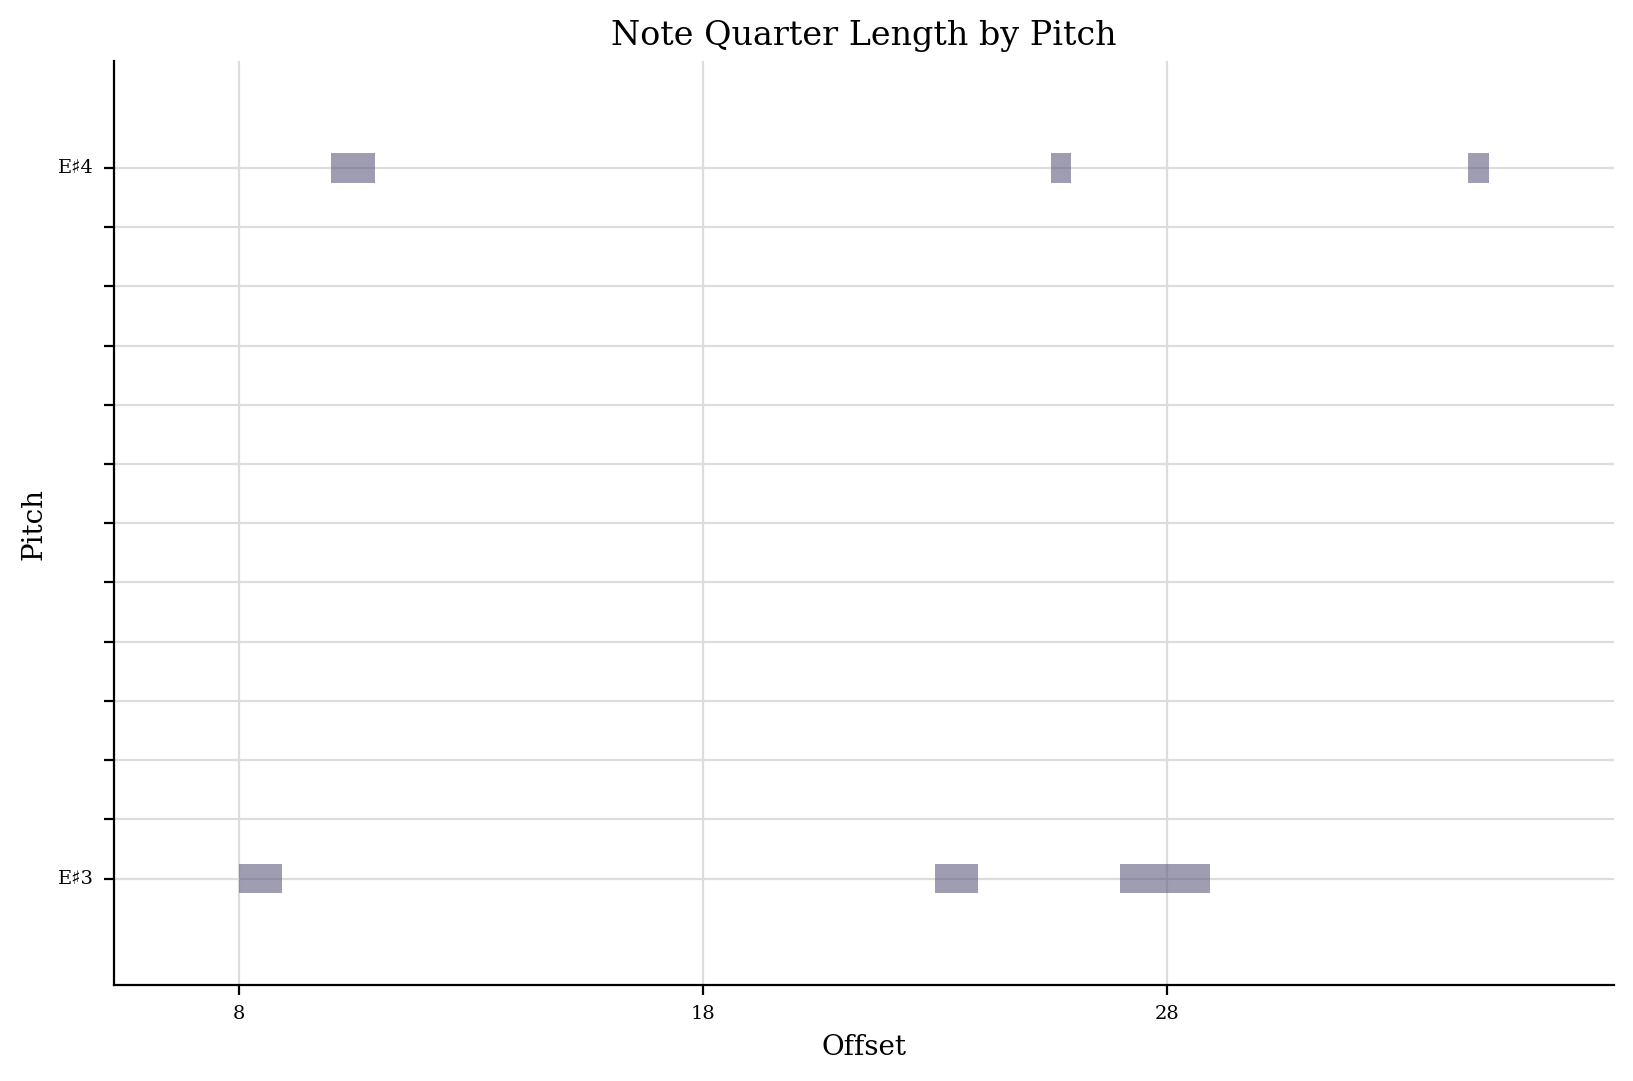

In [24]:
esharpStream.plot('pianoroll')